![title](https://pythonawesome.com/content/images/2018/05/scikit-learn.png)

In [1]:
import pandas as pd
import numpy as np
import copy

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# use seaborn plotting defaults
import seaborn as sns; sns.set()

from scipy import stats

from sklearn import datasets
from sklearn.datasets.samples_generator import make_blobs
from sklearn import svm
from sklearn.metrics import silhouette_samples, silhouette_score, accuracy_score, confusion_matrix
from sklearn.manifold import TSNE
from sklearn.utils.multiclass import unique_labels

# Support Vector Machine

We want to analyse a further class of classification algorithms known under the name of __Support Vector Machines__.

Let's start by an example.

## Working Example

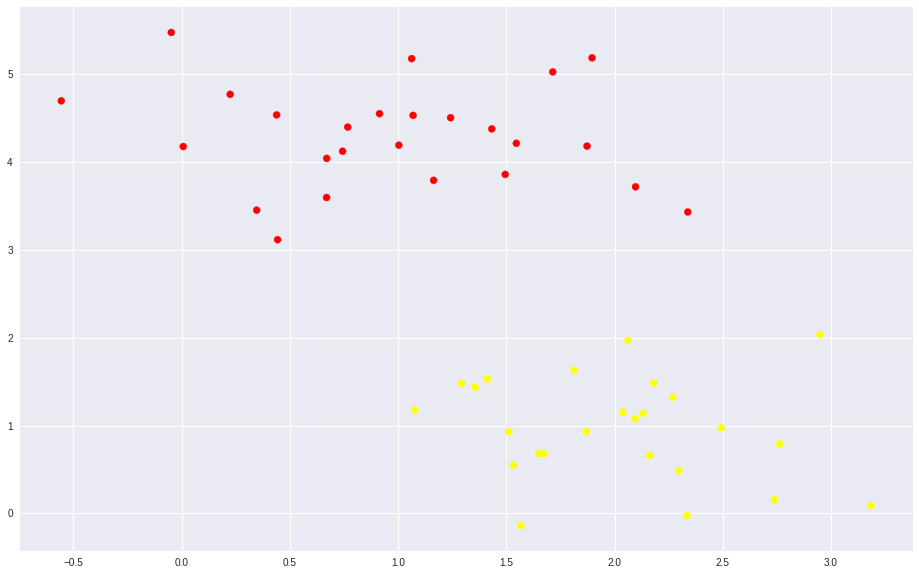

In [2]:
X, y = make_blobs(n_samples=50, centers=2,
                  random_state=0, cluster_std=0.60)

plt.figure(figsize = (16,10))
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn');

A linear discriminative classifier would attempt to draw a straight line separating the two sets of data, and thereby create a model for classification. 
For two dimensional data like that shown here, this is a task we could do by hand. But immediately we see a problem: there is more than one possible dividing line that can perfectly discriminate between the two classes!

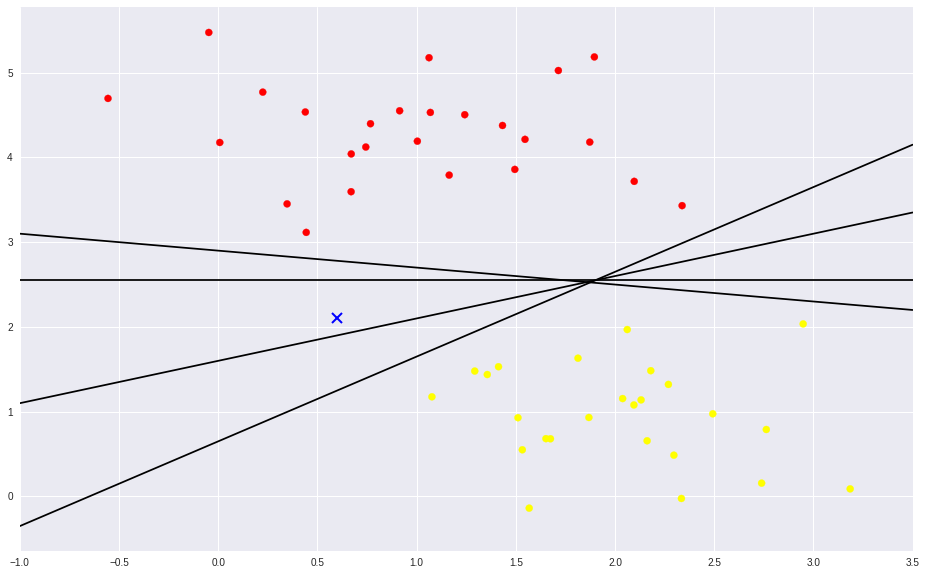

In [3]:
xfit = np.linspace(-1, 3.5)
plt.figure(figsize = (16,10))
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plt.plot([0.6], [2.1], 'x', color='blue', markeredgewidth=2, markersize=10)

for beta1, beta0 in [(1, 0.65), (0.5, 1.6), (-0.2, 2.9), (0, 2.55)]:
    plt.plot(xfit, beta1 * xfit + beta0, '-k')

plt.xlim(-1, 3.5);

These are four very different separators which, nevertheless, perfectly discriminate between these samples. Depending on which you choose, a new data point (e.g., the one marked by the blue "X" as a treasure in this plot) will be assigned a different label! Evidently our simple intuition of "drawing a line between classes" is not enough, and we need to think a bit deeper.

## Support Vector Machines: Maximizing the Margin

The thing we are going to implement is exactly the so-called __support vector machine__.

This class of algorithms offer one way to improve on this. 

The intuition is this: rather than simply drawing a zero-width line between the classes, we can draw around each line a margin of some width, up to the nearest point. Here is an example of how this might look.

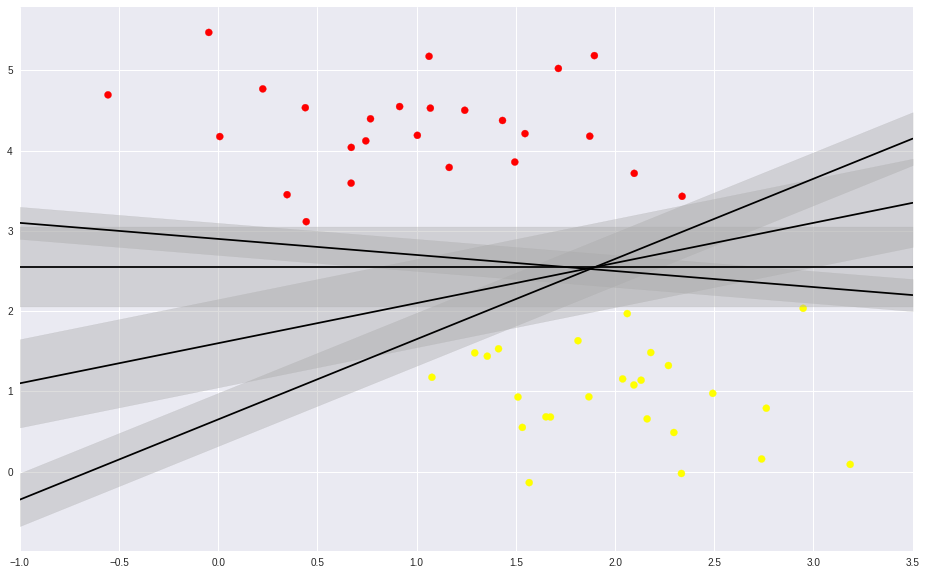

In [4]:
xfit = np.linspace(-1, 3.5)
plt.figure(figsize = (16,10))
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')

for beta1, beta0, delta in [(1, 0.65, 0.33), (0.5, 1.6, 0.55), (-0.2, 2.9, 0.2), (0, 2.55, 0.5)]:
    yfit = beta1 * xfit + beta0
    plt.plot(xfit, yfit, '-k')
    plt.fill_between(xfit, yfit - delta, yfit + delta, edgecolor='none',
                     color='#AAAAAA', alpha=0.4)

plt.xlim(-1, 3.5);

In support vector machines, the line that maximizes this margin is the one we will choose as the optimal model. 
> Support vector machines are an example of such a _maximum margin estimator_.

This is the reason this kind of SVM is also called __Large margin classifier__.

### Fitting a support vector machine

Now we want to write down a code to fit the support vector machine. This is easily done in `sklearn`.

In [5]:
model = svm.SVC(kernel='linear', C=1E10) # "Support vector classifier"
model.fit(X, y)

SVC(C=10000000000.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

Let's see the result of an actual fit to this data: we will use Scikit-Learn's support vector classifier to train an SVM model on this data. For the time being, we will use a linear kernel and set the `C` parameter to a very large number (we will discuss the meaning of these in more depth in a while).

To better visualize what's happening here, let's create a quick _convenience function_ that will plot SVM decision boundaries for us.

In [6]:
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['-.', '-', '-.'])
    
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, facecolors='none');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

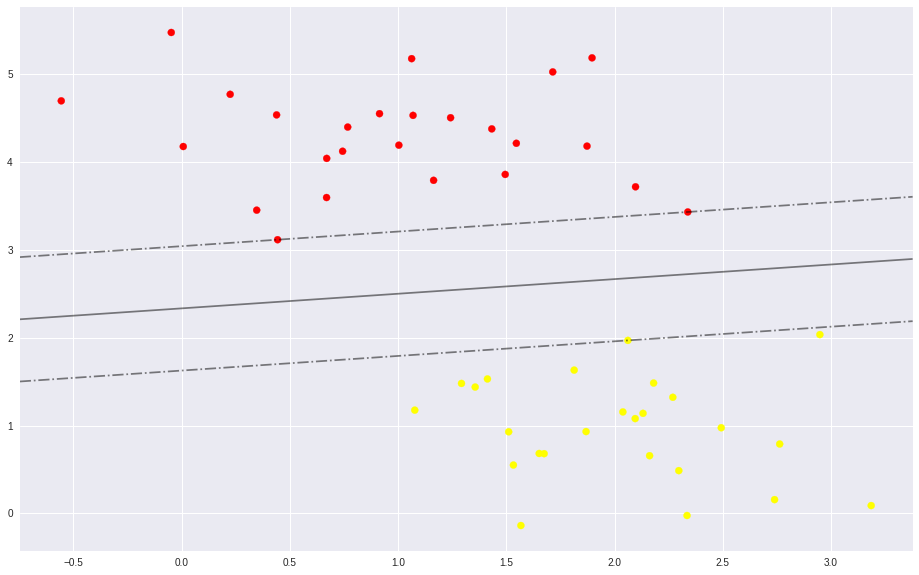

In [7]:
plt.figure(figsize=(16,10))
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(model);

This is the dividing line that maximizes the margin between the two sets of points. 
Notice that a few of the training points just touch the margin. These points are the _pivotal_ elements of this fit, and are known as the support vectors, and give the algorithm its name. In `Scikit-Learn`, the identity of these points are stored in the `support_vectors_` attribute of the classifier:

In [8]:
model.support_vectors_

array([[0.44359863, 3.11530945],
       [2.33812285, 3.43116792],
       [2.06156753, 1.96918596]])

A key to this classifier's success is that for the fit, __only the position of the support vectors matter__; any points further from the margin which are on the correct side do not modify the fit! Technically, this is because these points do not contribute to the loss function used to fit the model, so their position and number do not matter so long as they do not cross the margin.
This means the algorithms in this class are not really sensible to the addition of new data outside the support vectors!

We can see this, for example, if we plot the model learned from the first $60$ points and first $120$ points of this dataset.

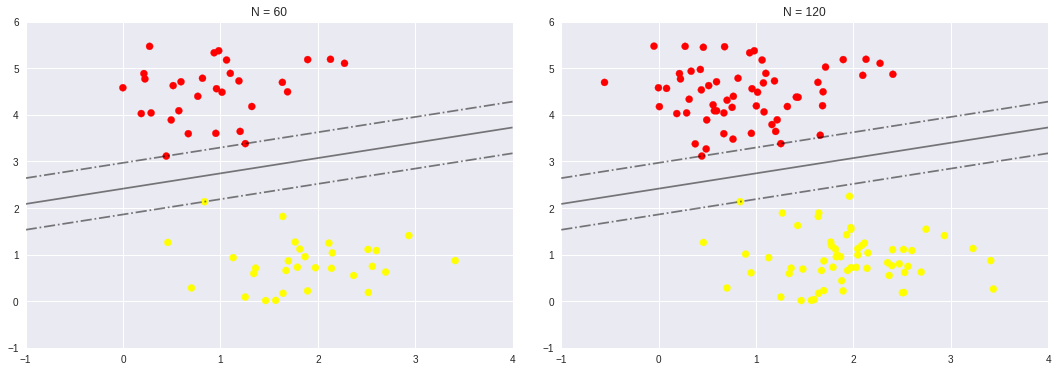

In [9]:
def plot_svm(N=10, ax=None):
    X, y = make_blobs(n_samples=200, centers=2,
                      random_state=0, cluster_std=0.60)
    X = X[:N]
    y = y[:N]
    model = svm.SVC(kernel='linear', C=1E10)
    model.fit(X, y)
    
    ax = ax or plt.gca()
    ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    ax.set_xlim(-1, 4)
    ax.set_ylim(-1, 6)
    plot_svc_decision_function(model, ax)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)
for axi, N in zip(ax, [60, 120]): # complete here
    plot_svm(N, axi)
    axi.set_title('N = {0}'.format(N))

As you can notice the line is not changed at all.


In the left panel, we see the model and the support vectors for $60$ training points. In the right panel, we have doubled the number of training points, but the model has not changed: the three support vectors from the left panel are still the support vectors from the right panel. This insensitivity to the exact behavior of distant points is one of the strengths of the SVM model.

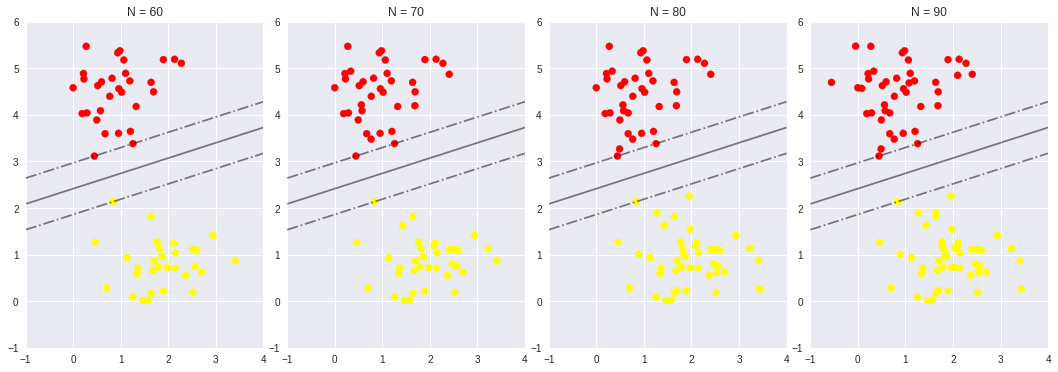

In [10]:
# complete here

fig, ax = plt.subplots(1, 4, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)
for axi, N in zip(ax, range(60, 100, 10)): 
    plot_svm(N, axi)
    axi.set_title('N = {0}'.format(N))

### Cost function

We would like to further investigate the behaviour of SVM with a large set of data, and furthermore understand the reason why SVM is not affected by adding new data outside the support vectors.

In order to do so, consider again the case of a logistic regression.

The cost function in such a case can be written as,
$$J(\beta) = -\frac{1}{m} \sum_i \mathrm{cost}_i \, ,$$
where we denoted as $\mathrm{cost}_i$ the contribution to the cost function of the $i$-th example.

Thus,

$$\mathrm{cost}_i = -y_i \ln\left(\frac{1}{1+e-\beta^TX_i}\right) - (1-y_i)\ln\left(1- \frac{1}{1+e-\beta^TX_i}\right)\, .$$

Let's study the two cases $y=0$ and $y = 1$ separately.

### $y=1$

In this case, we have 

$$\mathrm{cost} = - \ln\left(\frac{1}{1+e-\beta^TX_i}\right)\, .$$

Imagine to modify the cost function and take the following

$$ \tilde{\mathrm{cost}} = \begin{cases}\text{straight line}\, , \\
                                        0 & \text{for}\quad \beta^T X\geq 1\end{cases}$$
                                        
### $y=0$

The other case, where $y=0$, works the same, 

$$ \tilde{\mathrm{cost}} = \begin{cases}\text{straight line}\, , \\
                                        0 & \text{for}\quad \beta^T X\leq -1\end{cases}$$

![title](https://miro.medium.com/max/3400/1*qfZnRoVp-A0a4jMLwTBL6g.png)

In other words, the _hypotesis function_ for SVM is simple.

$$ h_\beta(x) = \begin{cases} 1 &\text{for} \quad \beta^T X >> 0\, , \\
                              0 &\text{for} \quad \beta^T X << 0\, . \end{cases}$$
                              
Commonly, and also in the plots above, we translated the conditions $\beta^T X >> 0$ and $\beta^T X << 0$ into $\beta^T X > 1$ and $\beta^T X < -1$ respectively.

Why such a choice? We will see this is exactly what determines the _margin_ of decision boundary.

The cost start to increase from $-1$ rather than from $0$, because SVM gives some punishment to both incorrect predictions and those close to decision boundary ( $0 < \beta^T X < 1$). 

We call support vectors points corresponding to data points just right on the margin, _i.e._ $\beta^T X = 1$, and data points between decision boundary and margin, _i.e._ $0 < \beta^T X < 1$. We will explain why some data points appear inside of margin later. As for why removing non-support vectors will not affect model performance, we are able to answer it now. Remember model fitting process is to minimize the cost function. Since there is no cost for non-support vectors at all, the total value of cost function won’t be changed by adding or removing them.

The cost function can be written explicitly as follows

$$ J(\beta) = \sum_i y_i\max\left(0, 1-\beta^TX_i\right) - (1-y_i)\max\left(0, 1 + \beta^TX_i\right)\, .$$

## Non-Linear SVM

Where SVM becomes extremely powerful is when it is combined with _kernels_. 
We have seen a version of kernels before, in one of the most basic application of machine learning: Linear Regression. There we projected our data into higher-dimensional space defined by polynomials and Gaussian basis functions, and thereby were able to fit for non-linear relationships with a linear classifier.

Recall the function `mapFeature` to calculate the terms of a given degree combining two features.

```python
def mapFeature(X1, X2, degree):
    out = np.ones(X.shape[0])[:,np.newaxis]
    for i in range(1, degree+1):
        for j in range(i+1):
            out = np.hstack((out, np.multiply(np.power(X1, i-j), np.power(X2, j))[:,np.newaxis]))
    return out
```

In SVM models, we can use a version of the same idea. To motivate the need for kernels, let's look at some data that is not linearly separable.

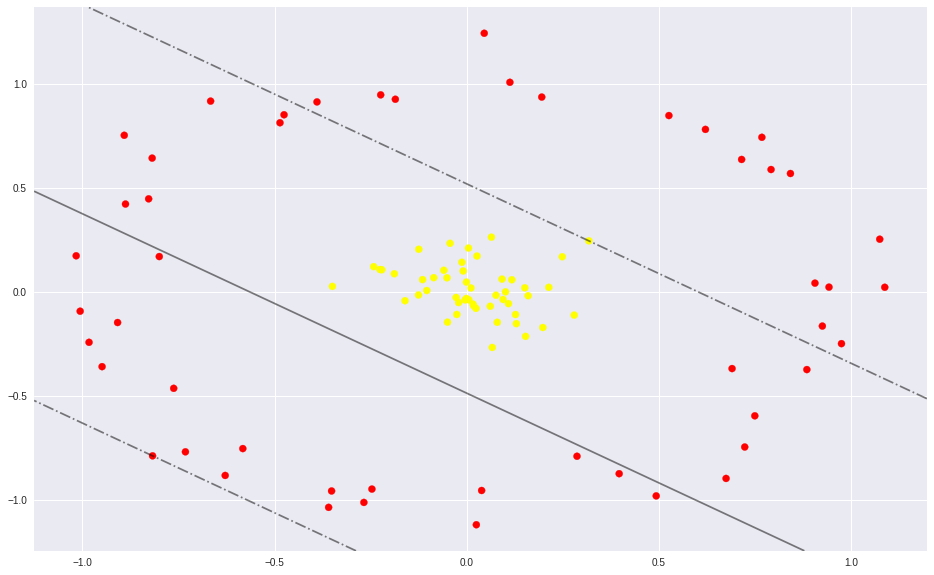

In [13]:
from sklearn.datasets.samples_generator import make_circles
X, y = make_circles(100, factor=.1, noise=.1) # Data distributed on circles.

clf = svm.SVC(kernel='linear').fit(X, y)

plt.figure(figsize=(16,10))
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf, plot_support=False);

It is quite clear that no linear discrimination will ever be able to separate this data. But we can draw a lesson from the linear regression, and think about how we might project the data into a higher dimension such that a linear separator would be sufficient. For example, one simple projection we could use would be to compute a radial basis function centered on the middle clump.

In [14]:
r = np.exp(-(X ** 2).sum(1))

We can visualize this extra data dimension using a three-dimensional plot.

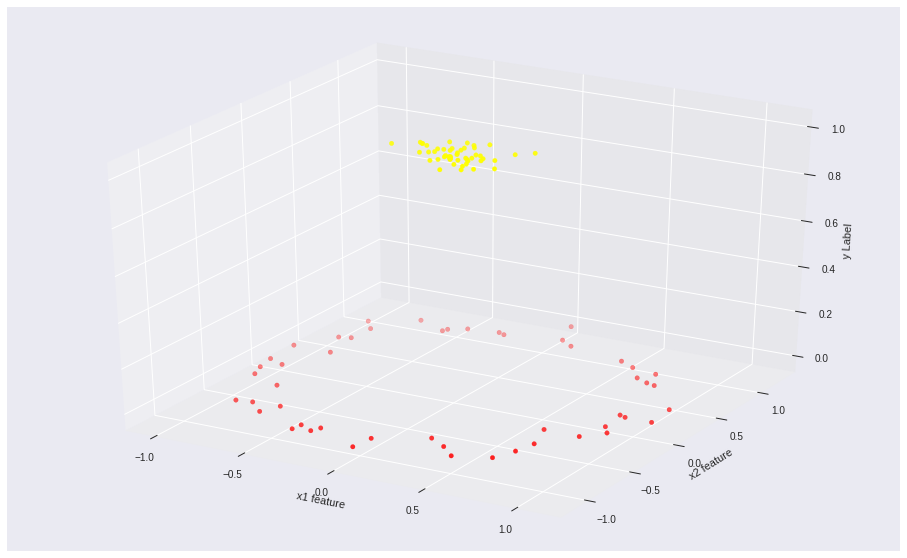

In [30]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111, projection='3d')


ax.scatter(X[:,0], X[:,1], y , c=y,cmap = 'autumn')

ax.set_xlabel('x1 feature')
ax.set_ylabel('x2 feature')
ax.set_zlabel('y Label')

plt.show()

We can see that with this additional dimension, the data becomes trivially linearly separable, by drawing a separating plane at, say, $r=0.7$.

Here we had to choose and carefully tune our projection: if we had not centered our radial basis function in the right location, we would not have seen such clean, linearly separable results. In general, the need to make such a choice is a problem: we would like to somehow automatically find the best basis functions to use.

One strategy to this end is to compute a basis function centered at every point in the dataset, and let the SVM algorithm sift through the results. This type of basis function transformation is known as a kernel transformation, as it is based on a similarity relationship (or _kernel_) between each pair of points.

A potential problem with this strategy—projecting $N$ points into $N$ dimensions—is that it might become very computationally intensive as N grows large. However, because of a neat little procedure known as the kernel trick, a fit on kernel-transformed data can be done implicitly—that is, without ever building the full N-dimensional representation of the kernel projection! This kernel trick is built into the SVM, and is one of the reasons the method is so powerful.

In Scikit-Learn, we can apply kernelized SVM simply by changing our linear kernel to an RBF (radial basis function) kernel, using the kernel model hyperparameter

### Excercise

Apply the SVM to iris and titanic datasets.
Compare the results with logistic regression and decision tree algorithms by calculating confusion matrix, and plotting learning curves.

Write a brief analysis of the results.

### Exercise

Make use of support vector machines to build a spam classifier.



# Final exercises

## Build your own non linear SVM

### Excercise

Apply the SVM to iris and titanic datasets.
Compare the results with logistic regression and decision tree algorithms by calculating confusion matrix, and plotting learning curves.

Write a brief analysis of the results.

## Exercise

# Final exercises

## Build your own non linear SVM